<a href="https://colab.research.google.com/github/IraniS12/202255202004_shilvia-irani-sukri/blob/main/deeplearning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
# 1. Install library tambahan
!pip install gdown -q

# 2. Download dataset dari Google Drive (pakai file ID)
import gdown
import zipfile
import os

In [4]:
# File ID dari link: https://drive.google.com/file/d/1KewFL9fwVCF4mwjTE0WKozmp9y8ZPs-k/view
file_id = '1KewFL9fwVCF4mwjTE0WKozmp9y8ZPs-k'
output = 'dataset.zip'
gdown.download(f'https://drive.google.com/uc?id={file_id}', output, quiet=False)


Downloading...
From (original): https://drive.google.com/uc?id=1KewFL9fwVCF4mwjTE0WKozmp9y8ZPs-k
From (redirected): https://drive.google.com/uc?id=1KewFL9fwVCF4mwjTE0WKozmp9y8ZPs-k&confirm=t&uuid=36f43a08-c832-4570-8567-58f3c9a57491
To: /content/dataset.zip
100%|██████████| 39.5M/39.5M [00:01<00:00, 30.1MB/s]


'dataset.zip'

In [5]:
# Ekstraksi file zip
with zipfile.ZipFile(output, 'r') as zip_ref:
    zip_ref.extractall('dataset_silpi')



In [6]:
import os
import shutil
import random
from tqdm import tqdm

base_dir = 'dataset_silpi'
output_dir = 'split_dataset'
train_split = 0.7
val_split = 0.2
test_split = 0.1

# Cek struktur awal
for root, dirs, files in os.walk(base_dir):
    print(root, len(dirs), len(files))

# Buat folder output (train, val, test)
for split in ['train', 'val', 'test']:
    split_path = os.path.join(output_dir, split)
    os.makedirs(split_path, exist_ok=True)

# Ambil semua nama kelas
class_names = [d for d in os.listdir(base_dir) if os.path.isdir(os.path.join(base_dir, d))]

for class_name in class_names:
    class_dir = os.path.join(base_dir, class_name)
    images = os.listdir(class_dir)
    random.shuffle(images)

    total = len(images)
    train_count = int(total * train_split)
    val_count = int(total * val_split)

    train_images = images[:train_count]
    val_images = images[train_count:train_count + val_count]
    test_images = images[train_count + val_count:]

    for split_name, split_images in zip(['train', 'val', 'test'], [train_images, val_images, test_images]):
        split_class_dir = os.path.join(output_dir, split_name, class_name)
        os.makedirs(split_class_dir, exist_ok=True)

        for img_name in tqdm(split_images, desc=f"Copying {split_name}/{class_name}"):
            src = os.path.join(class_dir, img_name)
            dst = os.path.join(split_class_dir, img_name)
            shutil.copy2(src, dst)


dataset_silpi 4 0
dataset_silpi/Foto buah rambutan 0 300
dataset_silpi/Foto buah jambu 0 300
dataset_silpi/Foto buah langsat 0 300
dataset_silpi/Foto buah jeruk 0 300


Copying test/Foto buah jeruk: 100%|██████████| 30/30 [00:00<00:00, 6881.17it/s]


In [7]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

IMG_SIZE = (224, 224)
BATCH_SIZE = 32

# Path direktori hasil split
train_dir = '/content/split_dataset/train'
val_dir = '/content/split_dataset/val'
test_dir = '/content/split_dataset/test'

# ImageDataGenerator untuk masing-masing
datagen = ImageDataGenerator(rescale=1./255)

train_gen = datagen.flow_from_directory(
    train_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True
)

val_gen = datagen.flow_from_directory(
    val_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

test_gen = datagen.flow_from_directory(
    test_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)


Found 840 images belonging to 4 classes.
Found 240 images belonging to 4 classes.
Found 120 images belonging to 4 classes.


In [8]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    zoom_range=0.2,
    horizontal_flip=True,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
)


In [9]:
# Callback scheduler
from tensorflow.keras.callbacks import ReduceLROnPlateau

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=5,
    min_lr=1e-6,
    verbose=1
)


In [10]:
# 5. Model MobileNetV3 (kode kamu)
from tensorflow.keras.applications import MobileNetV3Large
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam

base_model = MobileNetV3Large(input_shape=(224,224,3), include_top=False, weights='imagenet')
base_model.trainable = False  # Transfer learning

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.2)(x)
x = Dense(128, activation='relu')(x)
output_layer = Dense(train_gen.num_classes, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=output_layer)
model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

# 6. Training 50 epoch
history = model.fit(train_gen, validation_data=val_gen, epochs=100)

12683000/12683000 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 35s 802ms/step - accuracy: 0.2436 - loss: 1.4766 - val_accuracy: 0.2500 - val_loss: 1.3713
Epoch 2/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 3s 127ms/step - accuracy: 0.2691 - loss: 1.3831 - val_accuracy: 0.2500 - val_loss: 1.3810
Epoch 3/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 3s 126ms/step - accuracy: 0.2940 - loss: 1.3678 - val_accuracy: 0.3875 - val_loss: 1.3307
Epoch 4/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 6s 146ms/step - accuracy: 0.3093 - loss: 1.3505 - val_accuracy: 0.3167 - val_loss: 1.3315
Epoch 5/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 4s 139ms/step - accuracy: 0.3629 - loss: 1.3263 - val_accuracy: 0.5417 - val_loss: 1.3222
Epoch 6/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 4s 132ms/step - accuracy: 0.4167 - loss: 1.3086 - val_accuracy: 0.3292 - val_loss: 1.2793
Epoch 7/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 4s 149ms/step - accuracy: 0.4263 - loss: 1.2734 - val_accuracy: 0.2542 - val_loss: 1.2669
Epoch 8/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 3s 125ms/step - accuracy: 0.4247 - loss: 1.2671 - val_acc

4/4 ━━━━━━━━━━━━━━━━━━━━ 14s 2s/step


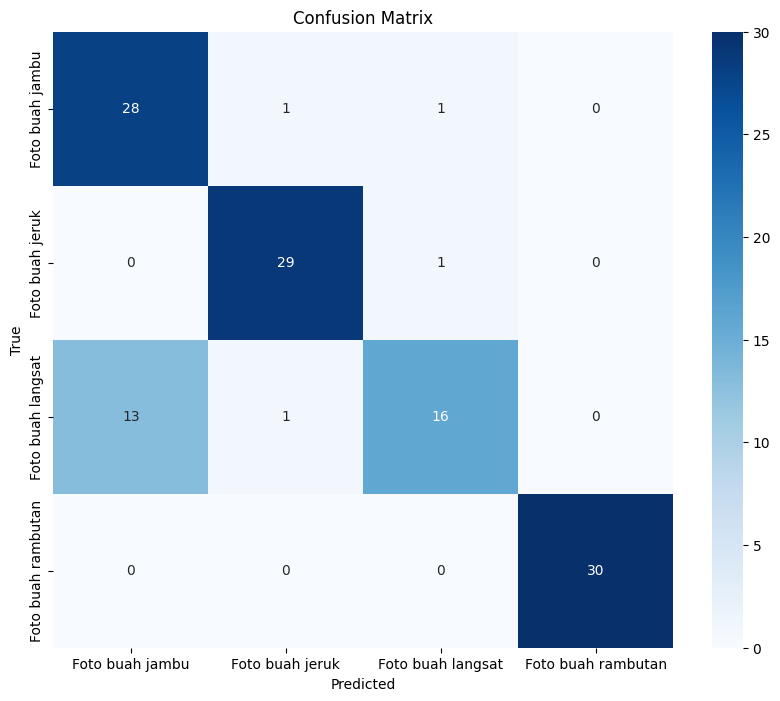

Classification Report:

                    precision    recall  f1-score   support

   Foto buah jambu       0.68      0.93      0.79        30
   Foto buah jeruk       0.94      0.97      0.95        30
 Foto buah langsat       0.89      0.53      0.67        30
Foto buah rambutan       1.00      1.00      1.00        30

          accuracy                           0.86       120
         macro avg       0.88      0.86      0.85       120
      weighted avg       0.88      0.86      0.85       120



In [12]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Langkah 1: Prediksi
pred_probs = model.predict(test_gen)
y_pred = np.argmax(pred_probs, axis=1)
y_true = test_gen.classes

# Langkah 2: Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
class_labels = list(test_gen.class_indices.keys())

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_labels, yticklabels=class_labels, cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Langkah 3: Classification Report
print("Classification Report:\n")
print(classification_report(y_true, y_pred, target_names=class_labels))


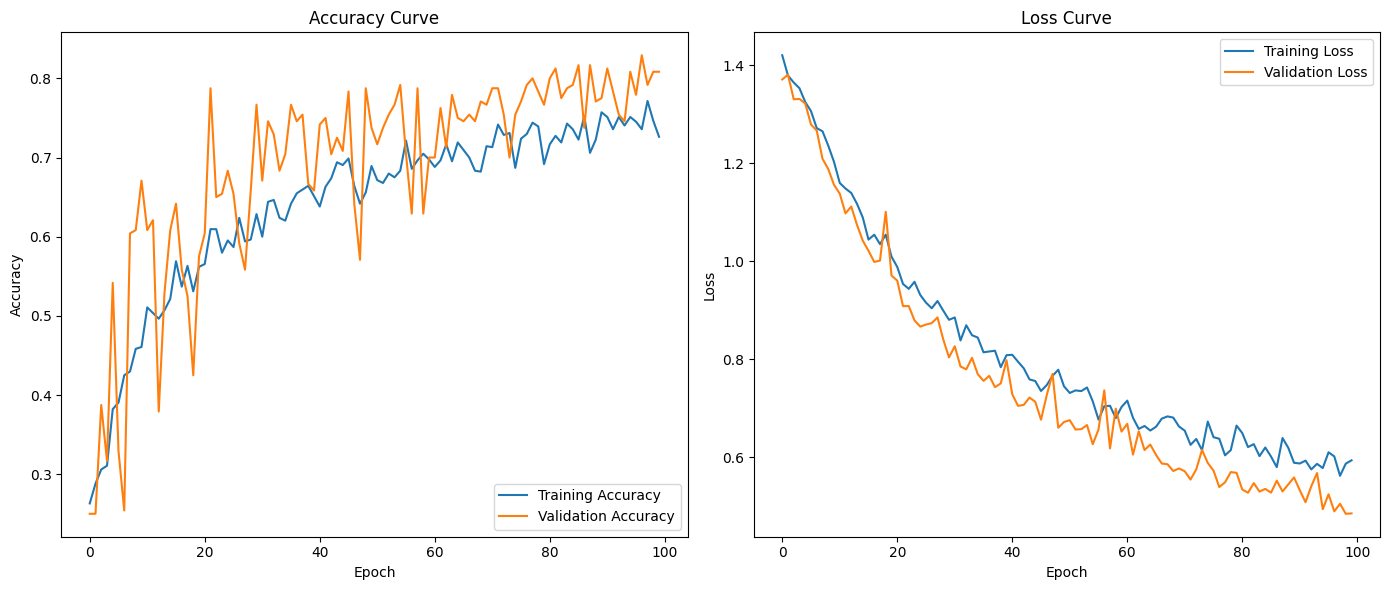

In [13]:
# Plot Accuracy dan Loss Curve
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(len(acc))

plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.title('Accuracy Curve')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.title('Loss Curve')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')

plt.tight_layout()
plt.show()
